In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set a global device to use for all PyTorch processes
if torch.backends.mps.is_available():
  DEVICE = torch.device("mps") # Apple Silicon Metal Performance Shaders
elif torch.cuda.is_available():
  DEVICE = torch.device("cuda") # GPU
else:
  DEVICE = torch.device("cpu") # CPU

## Problem 1 - Multi-Armed Bandit

An agent
repeatedly chooses one of 𝐾 “arms” (here, ad channels), observes a reward (conversion or not),
and must learn which arm is best while minimising total reward lost from suboptimal choices.
This is the simplest reinforcement learning setting — there is **no state**, **no dynamics**, just a
repeated decision under uncertainty.

The class below initialises a multi-armed bandit for 5 marketing channels which will randomly return a 1 or 0 payoff, determined by a Bernoulli distribution with unknown probabilities.

In [3]:
class AdChannelBandit:
    """K-armed bandit for ad channel selection with Bernoulli rewards."""
    def __init__(self):
        self.channels = ["Email", "Social Media", "Display Ads", "Search", "Influencer"]
        self.K = len(self.channels)
        self._rates = np.array([0.08, 0.15, 0.12, 0.25, 0.05])

    def pull(self, arm):
        """Select a channel and observe conversion (1) or not (0)."""
        return np.random.binomial(1, self._rates[arm])

    def optimal_arm(self):
        """Index of the channel with the highest true conversion rate."""
        return np.argmax(self._rates)

    def expected_reward(self, arm):
        """True conversion rate of the given channel (used for regret calculation)."""
        return self._rates[arm]

In [4]:
bandit = AdChannelBandit()
print("Channels:", bandit.channels)
print(f"Number of arms (K): {bandit.K}")

Channels: ['Email', 'Social Media', 'Display Ads', 'Search', 'Influencer']
Number of arms (K): 5


### 1a) Baseline: random policy

Regret measures the cost of not always pulling the best arm. Define per-round regret as
𝑝∗ −𝑝𝑎𝑡 , where 𝑝∗ = max𝑘 𝑝𝑘 is the best channel’s true conversion rate and 𝑝𝑎𝑡 is the conversion
rate of the channel chosen at round 𝑡. Cumulative regret sums this over all rounds:

$$
R_T = \sum_{t=1}^{T}(p^* - p_{a_t}\bigr)
$$

In [6]:
def run_random(bandit, T=2000, seed=None):
    """
    Run a random policy for T rounds.
    Returns:
        rewards: array of length T, reward at each round (0 or 1)
        arms_played: array of length T, index of arm chosen each round
    """
    rng = np.random.default_rng(seed)

    rewards = np.zeros(T, dtype=int)
    arms_played = np.zeros(T, dtype=int)

    for t in range(T):
        arm = rng.integers(0, bandit.K)   # uniform random in {0, ..., K-1}
        reward = bandit.pull(arm)

        arms_played[t] = arm
        rewards[t] = reward

    return rewards, arms_played

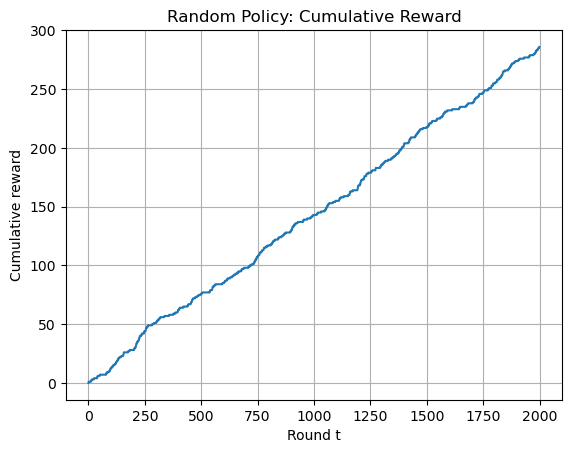

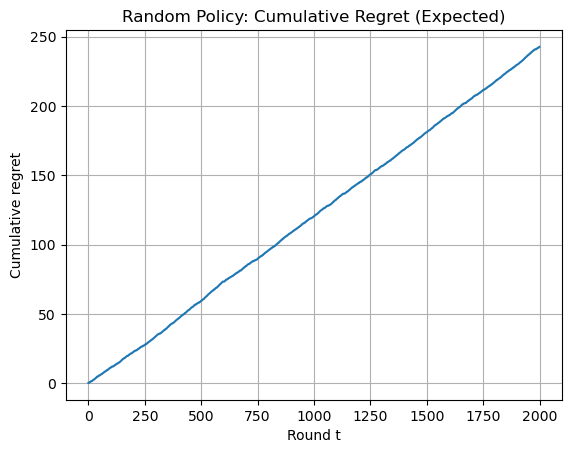

In [7]:
# Initialise the bandit and number of rounds
T = 2000
bandit = AdChannelBandit()

# Run the game
rewards, arms_played = run_random(bandit, T=T, seed=42)

# Compute the cumulative reward
cum_reward = np.cumsum(rewards)

# Retrieve the optimal arms (channels)
optimal = bandit.optimal_arm()

# Compute the optimal reward
p_star = bandit.expected_reward(optimal)

# Compute the played reward
p_played = np.array([bandit.expected_reward(a) for a in arms_played])

# Compute cumulative regret
inst_regret = p_star - p_played
cum_regret = np.cumsum(inst_regret)

# Plots
plt.figure()
plt.plot(cum_reward)
plt.xlabel("Round t")
plt.ylabel("Cumulative reward")
plt.title("Random Policy: Cumulative Reward")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(cum_regret)
plt.xlabel("Round t")
plt.ylabel("Cumulative regret")
plt.title("Random Policy: Cumulative Regret (Expected)")
plt.grid(True)
plt.show()

As expected, with a completely random policy, the regret grows linearly over time due to its constant expected value.

### 1b) Evaluating bandit algorithms

In [ ]:
# Helper functions for running multiple models and evaluation

def cumulative_regret(bandit, arms_played):
    """
    Function to compute cumulative regret 
    """
    optimal = bandit.optimal_arm()
    p_star = bandit.expected_reward(optimal)
    p_played = np.array([bandit.expected_reward(a) for a in arms_played])
    return np.cumsum(p_star - p_played)


def run_many(algorithm_fn, bandit_factory, T=2000, n_runs=50, seed=0, **algo_kwargs):
    """
    Runs algorithm_fn(bandit, T, ...) n_runs times with independent randomness.
    bandit_factory: callable returning a fresh bandit each run (safer practice).
    Returns:
        avg_cum_reward: (T,)
        avg_cum_regret: (T,)
        all_cum_rewards: (n_runs, T)
        all_cum_regrets: (n_runs, T)
    """
    all_cum_rewards = np.zeros((n_runs, T), dtype=float)
    all_cum_regrets = np.zeros((n_runs, T), dtype=float)

    for i in range(n_runs):
        bandit = bandit_factory()
        rewards, arms = algorithm_fn(bandit, T=T, seed=seed + i, **algo_kwargs)
        all_cum_rewards[i] = np.cumsum(rewards)
        all_cum_regrets[i] = cumulative_regret(bandit, arms)

    return all_cum_rewards.mean(axis=0), all_cum_regrets.mean(axis=0), all_cum_rewards, all_cum_regrets


def plot_with_band(all_curves, title, ylabel):
    """
    Plots mean curve with a light +/- 1 std band across runs.
    all_curves: (n_runs, T)
    """
    mean = all_curves.mean(axis=0)
    std = all_curves.std(axis=0)

    plt.plot(mean, label="mean")
    plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2)
    plt.title(title)
    plt.xlabel("Round t")
    plt.ylabel(ylabel)
    plt.grid(True)

#### **Algorithm 1**: 𝜖-greedy (𝜖 = 0.1)
With probability $\epsilon$, choose a random arm; otherwise choose the arm with the highest empirical mean reward. 

Update means incrementally: $\bar{r}_a$ ← $\bar{r}_a+\frac{1}{n_{a}}(r_{t}-\bar{r}_{a})$ 

We choose random arms, and we update the chosen arm's mean based on our reward from choosing it. This means that we choose the arm with the highest mean payoff 90% of the time, but 10% of the time we will try out a random new arm and update our mean payoff for that arm.

This is a simple way to model an agent who exploits their best option most of the time, but also explores some of the time.

In [9]:
def epsilon_greedy(bandit, T=2000, epsilon=0.1, seed=None):
    """Epsilon-greedy algorithm."""
    rng = np.random.default_rng(seed)
    K = bandit.K

    rewards = np.zeros(T, dtype=int)
    arms_played = np.zeros(T, dtype=int)

    counts = np.zeros(K, dtype=int)
    means = np.zeros(K, dtype=float)  # empirical mean reward per arm

    for t in range(T):
        explore = (rng.random() < epsilon)

        if explore or np.all(counts == 0):
            arm = rng.integers(0, K)
        else:
            arm = int(np.argmax(means))

        r = bandit.pull(arm)

        arms_played[t] = arm
        rewards[t] = r

        # incremental mean update: mean <- mean + (1/n) * (r - mean)
        counts[arm] += 1
        means[arm] += (r - means[arm]) / counts[arm]

    return rewards, arms_played

#### **Algorithm 2**: Upper Confidence Bound 1 (𝑐 = 2)
Pull each arm once, then choose:

$$\argmax_{a}  \bar{r}_{a} + c\sqrt{\frac{\ln{t}}{n_{a}}}$$

where $n_{a}$ is the number of times arm $a$ has been pulled.

1st term: expected reward from arm.

2nd term: additional weight given to arms that have been left relatively unexplored.

This is different from the greedy epsilon algorithm as it starts by pulling each arm once to build an initial expectation for each one.

Then, every period we choose the arm with the highest expected payoff; HOWEVER, we add an additional weight to arms that have been underexplored. This builds in an incentive for the bandit to spend time spreading their exploration across many good performing arms.

In [10]:
def ucb1(bandit, T=2000, c=2.0, seed=None):
    """UCB1 algorithm."""
    rng = np.random.default_rng(seed)  # only used for tie-breaking if you want
    K = bandit.K

    rewards = np.zeros(T, dtype=int)
    arms_played = np.zeros(T, dtype=int)

    counts = np.zeros(K, dtype=int)
    means = np.zeros(K, dtype=float)

    # Pull each arm once (or as many as possible if T < K)
    t = 0
    for arm in range(min(K, T)):
        r = bandit.pull(arm)
        arms_played[t] = arm
        rewards[t] = r
        counts[arm] += 1
        means[arm] += (r - means[arm]) / counts[arm]
        t += 1

    # Main loop
    for t_idx in range(t, T):
        tt = t_idx + 1  # use 1-based time for ln(t) as in the formula
        bonus = c * np.sqrt(np.log(tt) / counts)
        ucb_values = means + bonus

        # deterministic argmax is fine; if you want random tie-break:
        # best = np.flatnonzero(ucb_values == ucb_values.max()); arm = rng.choice(best)
        arm = int(np.argmax(ucb_values))

        r = bandit.pull(arm)
        arms_played[t_idx] = arm
        rewards[t_idx] = r

        counts[arm] += 1
        means[arm] += (r - means[arm]) / counts[arm]

    return rewards, arms_played


#### **Algorithm 4**: Thompson Sampling

Thompson Sampling maintains, for each arm $a \in \{1,\dots,K\}$, a Beta posterior
$\mathrm{Beta}(\alpha_a,\beta_a)$, initialised with the uniform prior
$\mathrm{Beta}(1,1)$.

At each round $t=1,\dots,T$:
$$
\theta_a \sim \mathrm{Beta}(\alpha_a,\beta_a)\quad \text{for all } a,
$$
$$
a_t = \arg\max_{a} \theta_a,
$$
pull arm $a_t$ and observe reward $r_t \in \{0,1\}$, then update:
$$
\alpha_{a_t} \leftarrow \alpha_{a_t} + r_t,\qquad
\beta_{a_t} \leftarrow \beta_{a_t} + (1-r_t).
$$

In [11]:
def thompson_sampling(bandit, T=2000, seed=None):
    """Thompson Sampling with Beta(1,1) priors."""
    rng = np.random.default_rng(seed)
    K = bandit.K

    rewards = np.zeros(T, dtype=int)
    arms_played = np.zeros(T, dtype=int)

    alpha = np.ones(K, dtype=float)  # successes + 1
    beta = np.ones(K, dtype=float)   # failures + 1

    for t in range(T):
        theta = rng.beta(alpha, beta)     # sample per arm
        arm = int(np.argmax(theta))
        r = bandit.pull(arm)

        arms_played[t] = arm
        rewards[t] = r

        alpha[arm] += r
        beta[arm] += (1 - r)

    return rewards, arms_played

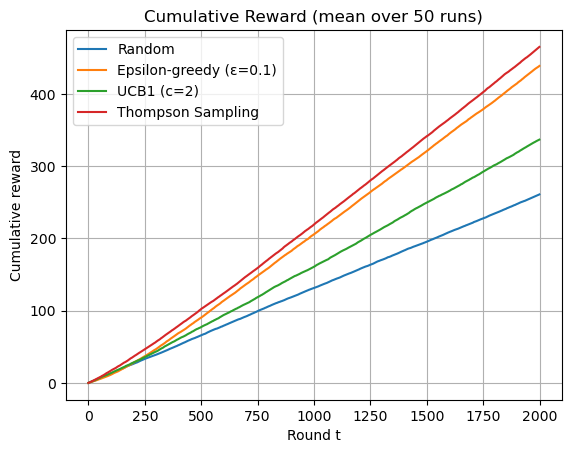

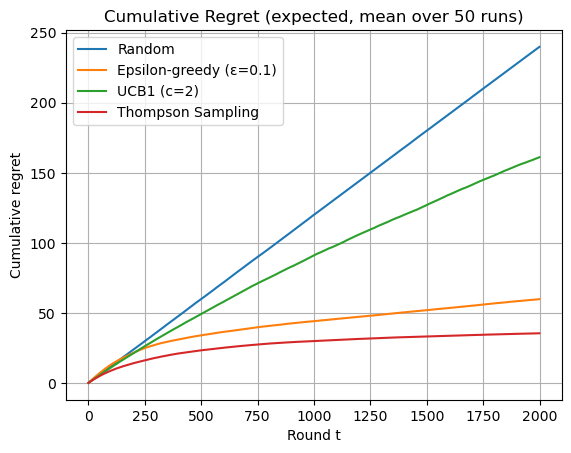

In [12]:
# --- Run 50 independent runs and plot comparisons ---

T = 2000
n_runs = 50

def make_bandit():
    return AdChannelBandit()

# Benchmark
avgR_rand, avgReg_rand, allR_rand, allReg_rand = run_many(run_random, make_bandit, T=T, n_runs=n_runs, seed=100)

# Algorithms
avgR_eps, avgReg_eps, allR_eps, allReg_eps = run_many(epsilon_greedy, make_bandit, T=T, n_runs=n_runs, seed=200, epsilon=0.1)
avgR_ucb, avgReg_ucb, allR_ucb, allReg_ucb = run_many(ucb1, make_bandit, T=T, n_runs=n_runs, seed=300, c=2.0)
avgR_ts,  avgReg_ts,  allR_ts,  allReg_ts  = run_many(thompson_sampling, make_bandit, T=T, n_runs=n_runs, seed=400)

# Plot: cumulative reward (mean across runs)
plt.figure()
plt.plot(avgR_rand, label="Random")
plt.plot(avgR_eps,  label="Epsilon-greedy (ε=0.1)")
plt.plot(avgR_ucb,  label="UCB1 (c=2)")
plt.plot(avgR_ts,   label="Thompson Sampling")
plt.title(f"Cumulative Reward (mean over {n_runs} runs)")
plt.xlabel("Round t")
plt.ylabel("Cumulative reward")
plt.grid(True)
plt.legend()
plt.show()

# Plot: cumulative regret (mean across runs)
plt.figure()
plt.plot(avgReg_rand, label="Random")
plt.plot(avgReg_eps,  label="Epsilon-greedy (ε=0.1)")
plt.plot(avgReg_ucb,  label="UCB1 (c=2)")
plt.plot(avgReg_ts,   label="Thompson Sampling")
plt.title(f"Cumulative Regret (expected, mean over {n_runs} runs)")
plt.xlabel("Round t")
plt.ylabel("Cumulative regret")
plt.grid(True)
plt.legend()
plt.show()